In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Register converters to plot datetime axis
pd.plotting.register_matplotlib_converters()

# Setup matplotlib plotting
%matplotlib inline

In [2]:
# Constants

# Dictionary containing name -> path of the hourly consumption dataset
HOURLY_CONSUMPTION_PATHS = {
    'AEP': 'data/AEP_hourly.csv',
    'COMED': 'data/COMED_hourly.csv',
    'DAYTON': 'data/DAYTON_hourly.csv',
    'DEOK': 'data/DEOK_hourly.csv',
    'DOM': 'data/DOM_hourly.csv',
    'DUQ': 'data/DUQ_hourly.csv',
    'EKPC': 'data/EKPC_hourly.csv',
    'FE': 'data/FE_hourly.csv',
    'NI': 'data/NI_hourly.csv',
    'PJME': 'data/PJME_hourly.csv',
    'PJMW': 'data/PJMW_hourly.csv'
}

In [3]:
# Load all datasets into Pandas DataFrame objects
files = HOURLY_CONSUMPTION_PATHS
ds = {k: pd.read_csv(files[k], names=['datetime', 'mwh'], header=0) for k in files.keys()}

In [4]:
# Sum up each dataset into a single one
ds = pd.concat(ds)
# Handle new index createb by concatenation
ds.reset_index(inplace=True)  # Store name of the dataset and index in it
ds.drop(ds.columns[1], axis=1, inplace=True)  # Drop index in old dataset
ds.rename(columns={ds.columns[0]: 'region'}, inplace=True) # Store dataset name (references to region)
# Handle datetime column
ds.datetime = pd.to_datetime(ds.datetime, format='%Y-%m-%d %H:%M:%S')

ds.head()

,region,datetime,mwh
0,AEP,2004-12-31 01:00:00,13478.0
1,AEP,2004-12-31 02:00:00,12865.0
2,AEP,2004-12-31 03:00:00,12577.0
3,AEP,2004-12-31 04:00:00,12517.0
4,AEP,2004-12-31 05:00:00,12670.0


In [5]:
# Check dataset shape

# Show total number of rows
print('There are {:d} rows (measurements) in the dataset'.format(ds.shape[0]))

# Show number of measurements per each region
for region in ds.region.unique():
    print('Region {:s}: {:d}'.format(
        region, ds[ds.region == region].shape[0], 
    ))

There are 1057271 rows (measurements) in the dataset
Region AEP: 121273
Region COMED: 66497
Region DAYTON: 121275
Region DEOK: 57739
Region DOM: 116189
Region DUQ: 119068
Region EKPC: 45334
Region FE: 62874
Region NI: 58450
Region PJME: 145366
Region PJMW: 143206


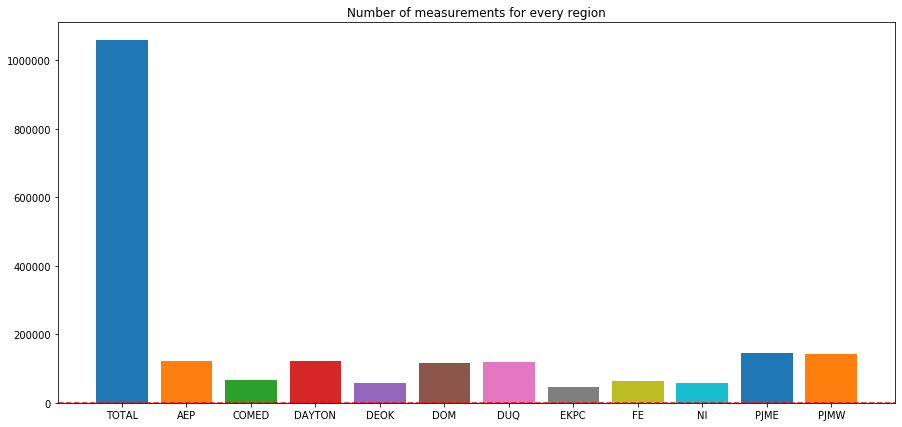

In [6]:
# Show graphically number of measurements
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Number of measurements for every region')
_ = ax.bar(['TOTAL'], [ds.shape[0]])

# Define regions
regions = ds.region.unique()

# Plot every region's data
for region in regions:
    _ = ax.bar([region], [ds[ds.region == region].shape[0]])
    
# Add line for missing data
_ = ax.axhline(y=209, color='r', ls='--')

# Show plot
_ = plt.plot()

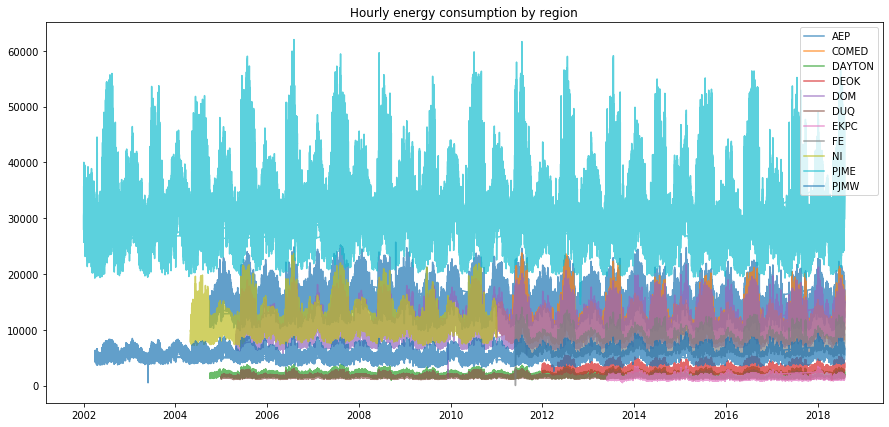

In [7]:
# Show raw time series

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Hourly energy consumption by region')

# Plot a new scatterplot for each region
for r in ds.region.unique():
    x = ds[ds.region == r]['datetime'].values
    y = ds[ds.region == r]['mwh'].values
    _ = ax.plot(x, y, alpha=0.7)
    _ = ax.plot()
    
# Show plot
_ = ax.legend(labels=ds.region.unique(), loc=1)
_ = plt.plot()

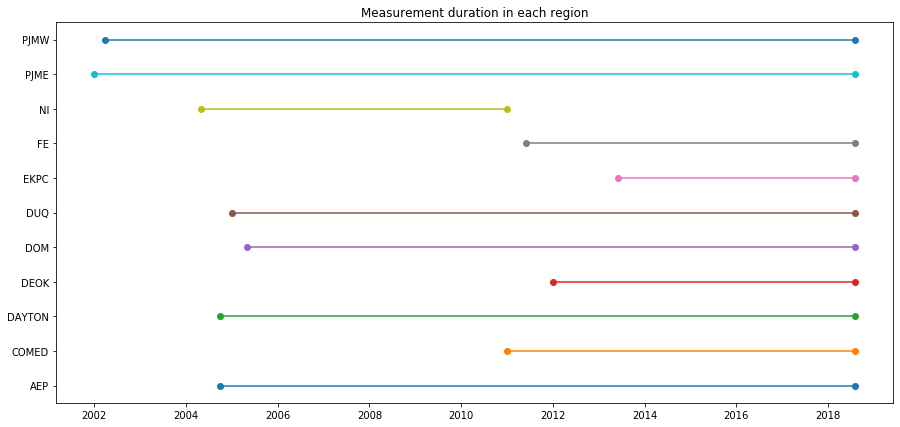

In [8]:
# Show time series length

# Get maximum and minimum dates for each region
durations = ds.groupby('region').agg({'datetime': [np.min, np.max]})
durations.reset_index(inplace=True)
durations.columns = ['region', 'begin', 'end']

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Measurement duration in each region')

# Plot a line for each region
for i, row in durations.iterrows():
    # Define x vector: datetime coordinates
    x = [row.begin, row.end]
    y = [i] * 2
    # Add plot
    _ = ax.plot(x, y, 'o-')
    
# Show plot
_ = ax.set_yticks(range(0, durations.shape[0]))
_ = ax.set_yticklabels(durations.region)
_ = plt.show()

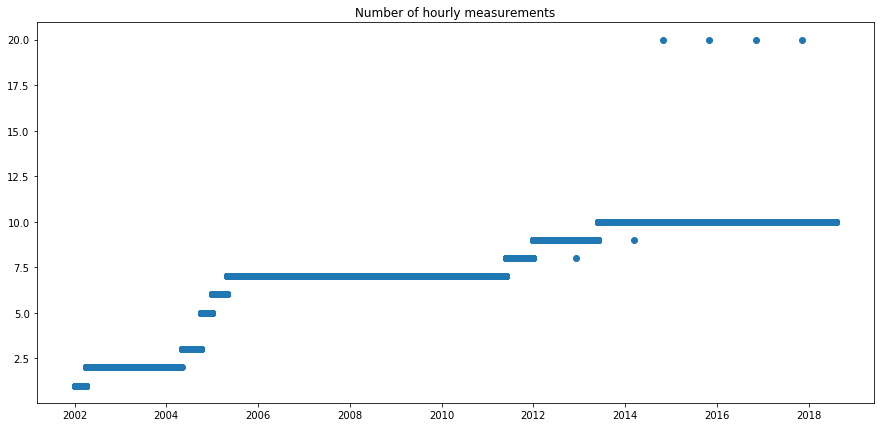

In [9]:
# Show number of daily registrations overall in a single hourly time slot

# Define all dates that whould be in dataset
timeline = pd.DataFrame(pd.date_range(freq='H', start=np.min(ds.datetime), end=np.max(ds.datetime)), 
                        columns=['datetime'])

# Get number of registrations in each time slot
registrations = ds.groupby('datetime').size().reset_index(name='counts')
# Check count in every time slot
registrations = timeline.merge(registrations, how='inner', on='datetime')

# Define x and y axis
x = registrations.datetime.values
y = registrations.counts.values

# Make plot
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Number of hourly measurements')
_ = ax.plot(x, y, 'o')
_ = plt.show()

In [10]:
# Check duplicates
print('There are {:d} duplicated entries'.format(sum(ds[['region', 'datetime']].duplicated())))

There are 40 duplicated entries


In [11]:
# There are some duplicates: delete by grouping and computing the mean
ds = ds.groupby(by=['region', 'datetime']).mean().reset_index()
ds.head()

# Check duplicates now
print('Now there are {:d} duplicated entries'.format(sum(ds[['region', 'datetime']].duplicated())))

Now there are 0 duplicated entries


In [12]:
# Spot whether there are missing hourly measurements in any of the time series

# Define regions
regions = ds.region.unique()

# Define series containing all dates in dataset
timeline = pd.DataFrame(pd.date_range(freq='H', start=np.min(ds.datetime), end=np.max(ds.datetime)),
                        columns=['datetime'])

# Plot a line for each region
for i, region in enumerate(regions):
    # Get the time series relative to current region
    ts = ds[ds.region == region]
    # Subset timeline to match current region timesitries range
    lb, ub = np.min(ts.datetime), np.max(ts.datetime)
    tl = timeline[(lb <= timeline.datetime) & (timeline.datetime <= ub)]
    ts = ts.merge(tl, how='right', on='datetime')
    ts.loc[ts.mwh.isnull(), 'region'] = region
    # Add missing measurements rows to dataframe
    ds = pd.concat([ds, ts[ts.mwh.isnull()]], axis=0)
    
# Sort dataset
ds.sort_values(by='datetime', ascending=False, inplace=True)
ds.head()

,region,datetime,mwh
602016,DUQ,2018-08-03,1656.0
914028,PJME,2018-08-03,35486.0
710216,FE,2018-08-03,8198.0
482952,DOM,2018-08-03,11385.0
187761,COMED,2018-08-03,13335.0


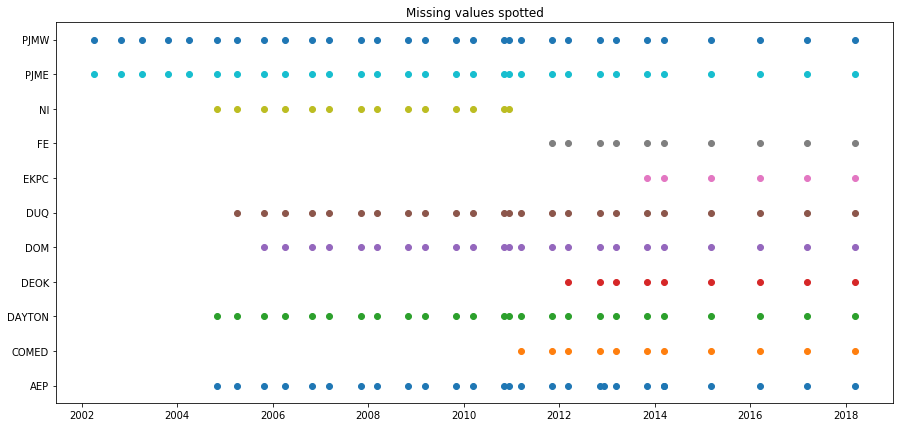

In [13]:
# Shwo spotted missing values

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Missing values spotted')

# Plot a line for each region
for i, region in enumerate(regions):
    # Get the time series relative to current region
    ts = ds[ds.region == region]
    # Define x vector: datetime coordinates
    x = ts[ts.mwh.isnull()]['datetime']
    y = [i] * len(x)
    # Add plot
    _ = ax.plot(x, y, 'o')
    
# Show plot
_ = ax.set_yticks(range(len(regions)))
_ = ax.set_yticklabels(regions)
_ = plt.show()

In [14]:
# How many missing values there are?
print('There are {:d} missing values in the whole dataset'.format(ds[ds.mwh.isnull()].shape[0]))

There are 209 missing values in the whole dataset


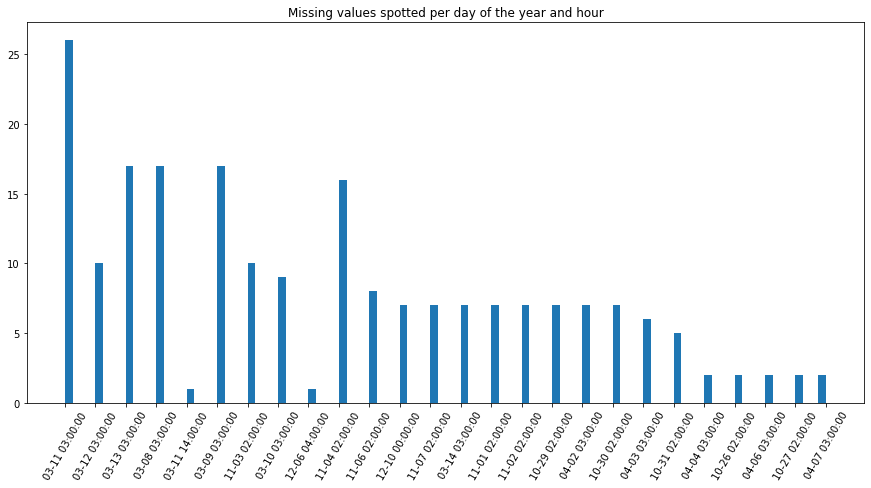

In [15]:
# Check days wether there are missing data

# Get missing values
missing = ds[ds.mwh.isnull()]['datetime']
missing = missing.dt.strftime('%m-%d %H:%M:%S') # Add date without year

# Make plot
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Missing values spotted per day of the year and hour')
_ = ax.hist(missing, bins=100)
_ = ax.tick_params(axis='x', labelrotation=60)
_ = plt.plot()

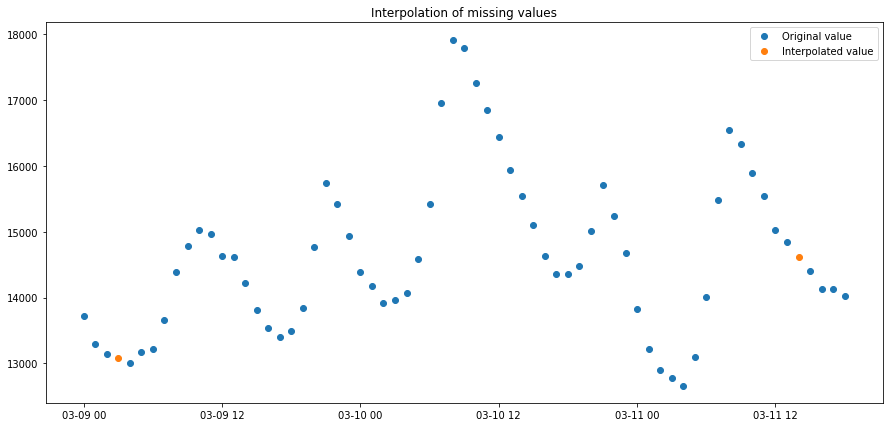

In [16]:
# Show interpolation example

# Retrieve some small interval with missing data for some series
aep1103 = ds[ds.datetime.between('2014-03-09 00:00:00', '2014-03-11 18:00:00') & (ds.region == 'AEP')]
aep1103 = aep1103.copy()

# Define filled and missing values
missing = aep1103.mwh.isnull()
filled = missing == False

# Fill missing values
aep1103.mwh = aep1103.mwh.interpolate('linear')

# Show either filled values and interpolated missing ones
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.set_title('Interpolation of missing values')
_ = ax.plot(aep1103[filled]['datetime'], aep1103[filled]['mwh'], 'o')
_ = ax.plot(aep1103[missing]['datetime'], aep1103[missing]['mwh'], 'o')
_ = ax.legend(['Original value', 'Interpolated value'])
_ = plt.plot()

In [17]:
# Interpolate mwh measure for every region

# Sort dataset descending
ds.sort_values(by='datetime', ascending=False, inplace=True)

# Loop through every region
for region in regions:
    # Get subset for this region
    ds_region = ds.loc[ds.region == region]
    # Get slice of dataframe for that region, then interpolate inplace
    ds.loc[ds.region == region, 'mwh'] = ds_region.mwh.interpolate('linear')
    
# Check if there are missing values
print('Now there are {:d} missing values'.format(sum(ds.mwh.isnull())))

Now there are 0 missing values


In [18]:
"""
From now on, only a subset of the original dataset will be considered:
- Since they offer much more data, we take only AEP, DAYTON, DOM, DUQ series
- We will cosider only a slice from 2006 to 2018
- PJME, PJMW are escluded since those are not localized hubs
"""

# Slice dataset accroding to selected regions
#ds_ = ds[ds.region.isin(['AEP', 'DAYTON', 'DOM', 'DUQ', 'PJME', 'PJMW'])]

# Define selected regions
regions = ['AEP', 'DAYTON', 'DOM', 'DUQ']
# Define selected date range
date_start = '2006-01-01 00:00:00'
date_end = np.max(ds.datetime)

# Initialize new dataset by setting new datetime column
ds_new = pd.DataFrame(pd.date_range(freq='H', start=date_start, end=date_end), 
                        columns=['datetime'])
# Sort dataframe descending
ds_new.sort_values(by='datetime', ascending=False, inplace=True)

# For each of the selected regions, add the relative timeseries as separate column
for region in regions:
    # Execute left join
    ds_new = ds_new.merge(
        ds[ds.region == region][['datetime', 'mwh']].rename(columns={'mwh': region}), 
        how='left', on='datetime'
    )
# Check new dataset
ds_new.head()

,datetime,AEP,DAYTON,DOM,DUQ
0,2018-08-03 00:00:00,14809.0,2042.0,11385.0,1656.0
1,2018-08-02 23:00:00,15964.0,2250.0,12390.0,1789.0
2,2018-08-02 22:00:00,17001.0,2405.0,13312.0,1901.0
3,2018-08-02 21:00:00,17303.0,2481.0,13832.0,1944.0
4,2018-08-02 20:00:00,17673.0,2554.0,14038.0,1966.0


In [19]:
# Check NA: no NA values detected
ds_new.isna().sum(axis=0)

datetime    0
AEP         0
DAYTON      0
DOM         0
DUQ         0
dtype: int64

In [20]:
# Save new dataset
ds_new.to_csv('data/ready.csv', index=False)